In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
IN_COLAB = 'COLAB_GPU' in os.environ.keys()

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
import gc
import sys
sys.path.append('../input/timm-module/Desktop/pytorch-image-models')
from timm import create_model
from fastai.vision.all import *
from sklearn.metrics import mean_squared_error
from time import time

import warnings
warnings.filterwarnings('ignore')

In [2]:
if IN_COLAB:
    dataset_path = Path('./')
else:
    dataset_path = Path('../input/petfinder-pawpularity-score/')
train = pd.read_csv(dataset_path/"train.csv")
test = pd.read_csv(dataset_path/"test.csv")
sample_submission = pd.read_csv(dataset_path/"sample_submission.csv")

print(train.shape, test.shape, sample_submission.shape)
train.head()

(9912, 14) (8, 13) (8, 2)


,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72


In [3]:
# set seed
seed = 999
random.seed(seed)
np.random.seed(seed)
set_seed(seed, reproducible=True)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms = True

BATCH_SIZE = 8

44


<AxesSubplot:>

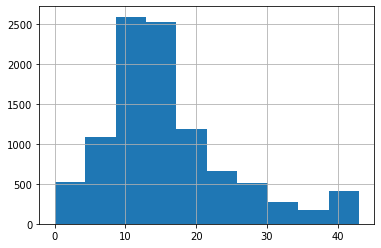

In [4]:
if 'Id' in train:
    train['path'] = train['Id'].map(lambda x:str(dataset_path/'train'/x)+'.jpg')
    train = train.drop(columns=['Id'])
train = train.sample(frac=1, random_state=seed).reset_index(drop=True) #shuffle dataframe
train['norm_score'] = train['Pawpularity']/100

#Sturges' rule スタージェスの公式（ヒストグラムの階級数の決め方） 
num_bins = int(np.floor(1+(3.3)*(np.log2(len(train)))))
print(num_bins)
train['bins'] = pd.cut(train['norm_score'], bins=num_bins, labels=False)
train['bins'].hist()

In [5]:
test['Pawpularity'] = [1]*len(test)
test['path'] = test['Id'].map(lambda x:str(dataset_path/'test'/x)+'.jpg')
test = test.drop(columns=['Id'])
train['norm_score'] = train['Pawpularity']/100

0 [  16   17   21 ... 9898 9899 9900]
1 [   6   10   28 ... 9896 9903 9905]
2 [   5    9   13 ... 9875 9895 9911]
3 [   2    7    8 ... 9893 9901 9910]
4 [  11   15   27 ... 9897 9906 9907]
5 [   0    1    3 ... 9904 9908 9909]


<AxesSubplot:>

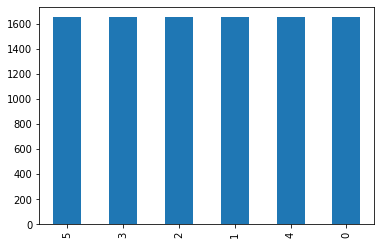

In [6]:
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

train['fold'] = -1

N_FOLDS = 6  # 5 to 6
strat_kfold = StratifiedKFold(n_splits=N_FOLDS, random_state=seed, shuffle=True)
for i, (_, train_index) in enumerate(strat_kfold.split(train.index, train['bins'])):
    print(i,train_index)
    train.iloc[train_index, -1] = i
    
train['fold'] = train['fold'].astype('int')
train.fold.value_counts().plot.bar()

In [7]:
def petfinder_rmse(input, target):
    return 100*torch.sqrt(F.mse_loss(F.sigmoid(input.flatten()), target))

**Swin Transformer**

In [8]:
from typing import List

model_versions: List[str] = ['v18', 'v23', 'mixup']
#model_versions: List[str] = ['v18', 'mixup']
#model_versions: List[str] = ['v18']
swin_val_preds: List[pd.DataFrame] = [pd.DataFrame()]*len(model_versions)
swin_test_preds: List[np.ndarray] = [np.zeros(test.shape[0])]*len(model_versions)


MAKE_META_TRAIN = False

for i in range(len(model_versions)):
    print(f'--- swin model {model_versions[i]} ---')
    for f in range(N_FOLDS):
        start = time()
        print(f'Fold {f} results')
        model_basedir = 'petfinder-swin-models/models' if i != 2 else 'petfinder-swin-mixup-models'
        model_name = f'../input/{model_basedir}/{model_versions[i]}/swin_model_fold_{f}.pkl'
        print(model_name)
        learn = load_learner(model_name, cpu=False)

        dls = ImageDataLoaders.from_df(
            train, #pass in train DataFrame
            #valid_pct=0.2, #80-20 train-validation random split
            seed=seed, #seed
            fn_col='path', #filename/path is in the second column of the DataFrame
            label_col='norm_score', #label is in the first column of the DataFrame
            y_block=RegressionBlock, #The type of target
            bs=BATCH_SIZE, #pass in batch size
            num_workers=8,
            item_tfms=Resize(224), #pass in item_tfms
            batch_tfms=setup_aug_tfms([Dihedral(), Brightness(), Contrast(), Hue(), Saturation()])
        )
        
        tta_n = 5
        tta_beta = 0.25
        
        if MAKE_META_TRAIN:
            val_df = train[train['fold'] == f].copy()
            val_dl = dls.test_dl(val_df)
            #val_preds, _ = learn.get_preds(dl=val_dl)
            val_preds, _ = learn.tta(dl=val_dl, n=tta_n, beta=tta_beta)
            oof_preds = val_df[['fold', 'Pawpularity']].copy()
            oof_preds['pred'] = val_preds.cpu().numpy().ravel()*100
            swin_val_preds[i] = pd.concat([swin_val_preds[i], oof_preds])

        test_dl = dls.test_dl(test)
        #test_preds, _ = learn.get_preds(dl=test_dl)
        test_preds, _ = learn.tta(dl=test_dl, n=tta_n, beta=tta_beta)
        tmp_test_preds = test_preds.cpu().numpy().ravel()*100
        swin_test_preds[i] = swin_test_preds[i] + tmp_test_preds / N_FOLDS

        end = time()
        print(f'{end - start} sec')

        del learn
        torch.cuda.empty_cache()
        gc.collect()

--- swin model v18 ---
Fold 0 results
../input/petfinder-swin-models/models/v18/swin_model_fold_0.pkl


20.267720460891724 sec
Fold 1 results
../input/petfinder-swin-models/models/v18/swin_model_fold_1.pkl


11.586963891983032 sec
Fold 2 results
../input/petfinder-swin-models/models/v18/swin_model_fold_2.pkl


10.090507745742798 sec
Fold 3 results
../input/petfinder-swin-models/models/v18/swin_model_fold_3.pkl


9.823734283447266 sec
Fold 4 results
../input/petfinder-swin-models/models/v18/swin_model_fold_4.pkl


10.061646223068237 sec
Fold 5 results
../input/petfinder-swin-models/models/v18/swin_model_fold_5.pkl


9.871325731277466 sec
--- swin model v23 ---
Fold 0 results
../input/petfinder-swin-models/models/v23/swin_model_fold_0.pkl


9.540814876556396 sec
Fold 1 results
../input/petfinder-swin-models/models/v23/swin_model_fold_1.pkl


9.570797681808472 sec
Fold 2 results
../input/petfinder-swin-models/models/v23/swin_model_fold_2.pkl


9.626376628875732 sec
Fold 3 results
../input/petfinder-swin-models/models/v23/swin_model_fold_3.pkl


9.402438879013062 sec
Fold 4 results
../input/petfinder-swin-models/models/v23/swin_model_fold_4.pkl


9.946954727172852 sec
Fold 5 results
../input/petfinder-swin-models/models/v23/swin_model_fold_5.pkl


10.1623854637146 sec
--- swin model mixup ---
Fold 0 results
../input/petfinder-swin-mixup-models/mixup/swin_model_fold_0.pkl


9.83319616317749 sec
Fold 1 results
../input/petfinder-swin-mixup-models/mixup/swin_model_fold_1.pkl


10.071683168411255 sec
Fold 2 results
../input/petfinder-swin-mixup-models/mixup/swin_model_fold_2.pkl


10.294804811477661 sec
Fold 3 results
../input/petfinder-swin-mixup-models/mixup/swin_model_fold_3.pkl


9.766517877578735 sec
Fold 4 results
../input/petfinder-swin-mixup-models/mixup/swin_model_fold_4.pkl


9.813615798950195 sec
Fold 5 results
../input/petfinder-swin-mixup-models/mixup/swin_model_fold_5.pkl


9.962904453277588 sec


In [9]:
print(len(swin_val_preds), len(swin_test_preds))

for i in range(len(swin_val_preds)):
    if MAKE_META_TRAIN:
        swin_val_preds[i] = swin_val_preds[i].sort_index()

3 3


In [10]:
def rmse_oof(_oof_df:pd.DataFrame, fold:int=None):
    oof_df = _oof_df.copy()
    if fold is not None:
        oof_df = oof_df[oof_df["fold"] == fold]
    target = oof_df['Pawpularity'].values
    y_pred = oof_df['pred'].values
    #if fold is not None:
    #    print(f'fold {fold}: {petfinder_rmse(y_pred, target)}')
    if fold is not None:
        print(f'fold {fold}: {mean_squared_error(target, y_pred, squared=False)}')
    else:
        print(f'overall: {mean_squared_error(target, y_pred, squared=False)}')

In [11]:
if MAKE_META_TRAIN:
    for i in range(len(model_versions)):
        print(f'--- rmse {model_versions[i]} ---')
        for f in range(N_FOLDS):
            rmse_oof(swin_val_preds[i], f)
        rmse_oof(swin_val_preds[i])

**Meta Model**

In [12]:
if MAKE_META_TRAIN:
    meta_train = pd.DataFrame({
        'swin_v18': swin_val_preds[0]['pred'],
        'swin_v23': swin_val_preds[1]['pred'],
        'swin_mixup': swin_val_preds[2]['pred']
    })
    meta_train.to_csv('meta_train.csv', index=False)
else:
    meta_train_path = f'../input/petfinder-meta-train2/meta_train/meta_train_tta_n5b025.csv'
    print(f'meta_train file: {meta_train_path}')
    meta_train = pd.read_csv(meta_train_path)

meta_test = pd.DataFrame({
    'swin_v18': swin_test_preds[0],
    'swin_v23': swin_test_preds[1],
    'swin_mixup': swin_test_preds[2]
})

meta_train = meta_train.drop(columns=['swin_v23'])
meta_test = meta_test.drop(columns=['swin_v23'])
meta_train
#meta_test

meta_train file: ../input/petfinder-meta-train2/meta_train/meta_train_tta_n5b025.csv


,swin_v18,swin_mixup
0,36.831020,39.392727
1,43.571518,41.662136
2,34.644890,34.373917
3,23.915410,30.258919
4,32.276900,32.968754
...,...,...
9907,46.097027,46.701380
9908,51.588608,45.092804
9909,25.343414,31.874544
9910,34.999970,32.079643


In [13]:
model = None
test_preds = None

from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold

n_splits = 5
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
oof_preds = np.zeros(train.shape[0])
final_test_preds = np.zeros(test.shape[0])

for trn_idx, val_idx in kfold.split(meta_train):
    X_train, X_val = meta_train.iloc[trn_idx], meta_train.iloc[val_idx]
    y_train, y_val = train.iloc[trn_idx]['Pawpularity'], train.iloc[val_idx]['Pawpularity']
    
    meta_model = Ridge(alpha=100.0)
    meta_model.fit(X_train, y_train)
    print(meta_model.coef_, meta_model.intercept_)
    
    oof_preds[val_idx] = meta_model.predict(X_val)
    final_test_preds += meta_model.predict(meta_test)/n_splits
    
loss = mean_squared_error(train['Pawpularity'], oof_preds, squared=False)
print(f'RMSE loss: {loss}')
print(final_test_preds)

[0.55438651 0.49701719] -2.1959375568624964
[0.56851489 0.49530841] -2.4435393697837995
[0.59325103 0.48217011] -3.006665576450928
[0.57025723 0.49294301] -2.5610553359371693
[0.59335999 0.42538839] -1.1471921308732078
RMSE loss: 17.589700529788367
[37.10527974 38.48773059 38.39492267 38.75688029 38.09511714 38.92323222
 38.76892699 38.84647268]


In [14]:
sample_df = pd.read_csv(dataset_path/'sample_submission.csv')
sample_df['Pawpularity'] = final_test_preds
sample_df.to_csv('submission.csv',index=False)

In [15]:
pd.read_csv('submission.csv')

,Id,Pawpularity
0,4128bae22183829d2b5fea10effdb0c3,37.105280
1,43a2262d7738e3d420d453815151079e,38.487731
2,4e429cead1848a298432a0acad014c9d,38.394923
3,80bc3ccafcc51b66303c2c263aa38486,38.756880
4,8f49844c382931444e68dffbe20228f4,38.095117
5,b03f7041962238a7c9d6537e22f9b017,38.923232
6,c978013571258ed6d4637f6e8cc9d6a3,38.768927
7,e0de453c1bffc20c22b072b34b54e50f,38.846473
